# 01 Check on CartPole
目的：CartPoleにおいて，ChainerRL・自作モジュールの性能比較を行う．  
結果：DQN・A2Cにおいて同等程度の性能を示している．

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

np.set_printoptions(precision=3)
import importlib

import sys
sys.path.append('../RLPack')

In [2]:
import gym
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


---
## 1.ChainerRL

In [3]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl

In [4]:
class QFunction(chainer.Chain):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, 50)
            self.l1 = L.Linear(50, 50)
            self.l2 = L.Linear(50, n_actions)
            
    def __call__(self, X, test=False):
        h = F.tanh(self.l0(X))
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))
    
q_func = QFunction(env.observation_space.shape[0], env.action_space.n)  # 4, 2
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

gamma = 0.95
explorer = chainerrl.explorers.LinearDecayEpsilonGreedy(
    start_epsilon=1.0, end_epsilon=0.1, decay_steps=200,
    random_action_func=env.action_space.sample
)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10**6)
phi = lambda x: x.astype(np.float32, copy=False)

agent = chainerrl.agents.DQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1, target_update_interval=100,
    phi=phi
)


##################################################################
num_episodes = 200
count = 0
for episode in range(num_episodes):
    state = env.reset()
    done = False
    reward = 0
    R = 0
    for t in range(200):
        count += 1
        action = agent.act_and_train(state, reward)  # 行動し，experienceをbufferに送る
        state, reward, done, info = env.step(action)
        R += reward
        if done:
            break
    agent.stop_episode_and_train(state, reward, done)  # Reward, S_next, doneがbufferに送られ，学習開始．
    
    if episode%10==0:
        print('episode:{}, R:{}, statistics:{}'
              .format(episode, R, agent.get_statistics()))
print('total steps = ', count)

episode:0, R:14.0, statistics:[('average_q', 0.004602565474983686), ('average_loss', 0), ('n_updates', 0)]
episode:10, R:10.0, statistics:[('average_q', 0.04147870649536789), ('average_loss', 0), ('n_updates', 0)]
episode:20, R:9.0, statistics:[('average_q', 0.06749663620183508), ('average_loss', 0), ('n_updates', 0)]
episode:30, R:11.0, statistics:[('average_q', 0.09251375962334248), ('average_loss', 0), ('n_updates', 0)]
episode:40, R:9.0, statistics:[('average_q', 0.11241748054220842), ('average_loss', 0), ('n_updates', 0)]
episode:50, R:10.0, statistics:[('average_q', 0.14712229730529922), ('average_loss', 0.11643785308849185), ('n_updates', 38)]
episode:60, R:9.0, statistics:[('average_q', 0.2523475984032852), ('average_loss', 0.26348949540915556), ('n_updates', 133)]
episode:70, R:10.0, statistics:[('average_q', 0.4286795355031309), ('average_loss', 0.3093360234743357), ('n_updates', 227)]
episode:80, R:11.0, statistics:[('average_q', 0.665525567903867), ('average_loss', 0.263400

---
## 2.自作モジュールの検証

In [5]:
# 自作モジュール用にラッパーでAPIを修正．
class EnvLap(object):
    def __init__(self, env):
        self.env = env
        self.reset()
        
    def step(self, action, auto_reset=True, verbose=False):
        state_next, reward, done, _ = self.env.step(action.ravel()[0])
        self._state = np.copy(np.array(state_next))     
        state_next = self.state()
        reward = np.array(reward)
        done = np.copy(np.array(done))
        
        if done==True:
            self.reset()
                             
        return state_next, reward.reshape(1, 1), np.array(['ok']).reshape(1, 1), done.reshape(1, 1)
        
    def reset(self):
        self._state = self.env.reset()
        
    def shapes(self):
        return [[self.env.observation_space.shape[0]]]
        
    def state(self):
        return [np.copy(self._state).reshape(1, -1), ]
    

In [6]:
env_lap = EnvLap(env)
print(env_lap.state())
for t in range(20):
    print(env_lap.step(np.array([[0,]])))

[array([[0.031, 0.027, 0.042, 0.041]])]
([array([[ 0.032, -0.168,  0.043,  0.347]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[ 0.029, -0.364,  0.049,  0.653]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[ 0.021, -0.56 ,  0.063,  0.961]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[ 0.01 , -0.756,  0.082,  1.272]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[-0.005, -0.952,  0.107,  1.589]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[-0.024, -1.148,  0.139,  1.913]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[-0.047, -1.344,  0.177,  2.246]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[False]]))
([array([[-0.074, -1.541,  0.222,  2.587]])], array([[1.]]), array([['ok']], dtype='<U2'), array([[ True]]))
([array([[ 0.042, -0.234, -0.013,  0.276]])], array([[1.]]), array([['ok']], dtype='<U2'

### 2.1.DQN

In [7]:
from keras import layers
from keras import regularizers
from keras import models

def gen_model(input_shapes=[[1], [10], [10]], n_outputs=10, \
              hidden_dims=[512, 256, 128, 64, 32], reg_l1=0.0, reg_l2=0.0, \
              duel=False, duel_value_dim=10, duel_advantage_dim=10,
              input_reg=False, input_min=-10, input_max=10, \
              output_reg=False, output_min=-10, output_max=10):
    input_ts = [layers.Input(input_shape) for input_shape in input_shapes]
    if 2 <= len(input_ts):
        input_concat = layers.concatenate(input_ts, axis=-1)
    else:
        input_concat = layers.Lambda(lambda x: x)(input_ts[0])  # 恒等レイヤー．

    if input_reg:
        input_concat = layers.Lambda(lambda x: x/(input_max-input_min))(input_concat)

    for i, hidden_dim in enumerate(hidden_dims):
        if i == 0:
            x = layers.Dense(hidden_dim, activation='tanh', kernel_regularizer=regularizers.l1_l2(reg_l1, reg_l2))(input_concat)
        else:
            x = layers.Dense(hidden_dim, activation='tanh', kernel_regularizer=regularizers.l1_l2(reg_l1, reg_l2))(x)

    Q_head = layers.Dense(n_outputs, activation='linear', kernel_regularizer=regularizers.l1_l2(reg_l1, reg_l2))(x)

    return models.Model(input_ts, [Q_head,])

Using TensorFlow backend.


In [8]:
# 自作モジュールは利得ベースなので，ChainerRLで表示したRと基準が異なる．
gamma = 0.95
print('ChainerRLにおける200相当の価値= {}'.format((1 + 0.95**(200-1) * 0.95) / (1-0.95)))
1 * 0.95**200

ChainerRLにおける200相当の価値= 20.00070105332496


3.50526662488287e-05

Instructions for updating:
Colocations handled automatically by placer.
start testing... :  2019-11-16 10:56:53.064423
start trial 1/1 trial...


  2%|▏         | 480/20000 [00:00<12:31, 25.98it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████| 20000/20000 [02:38<00:00, 126.48it/s]


end testing... :  2019-11-16 10:59:32.047223
loss and reward history


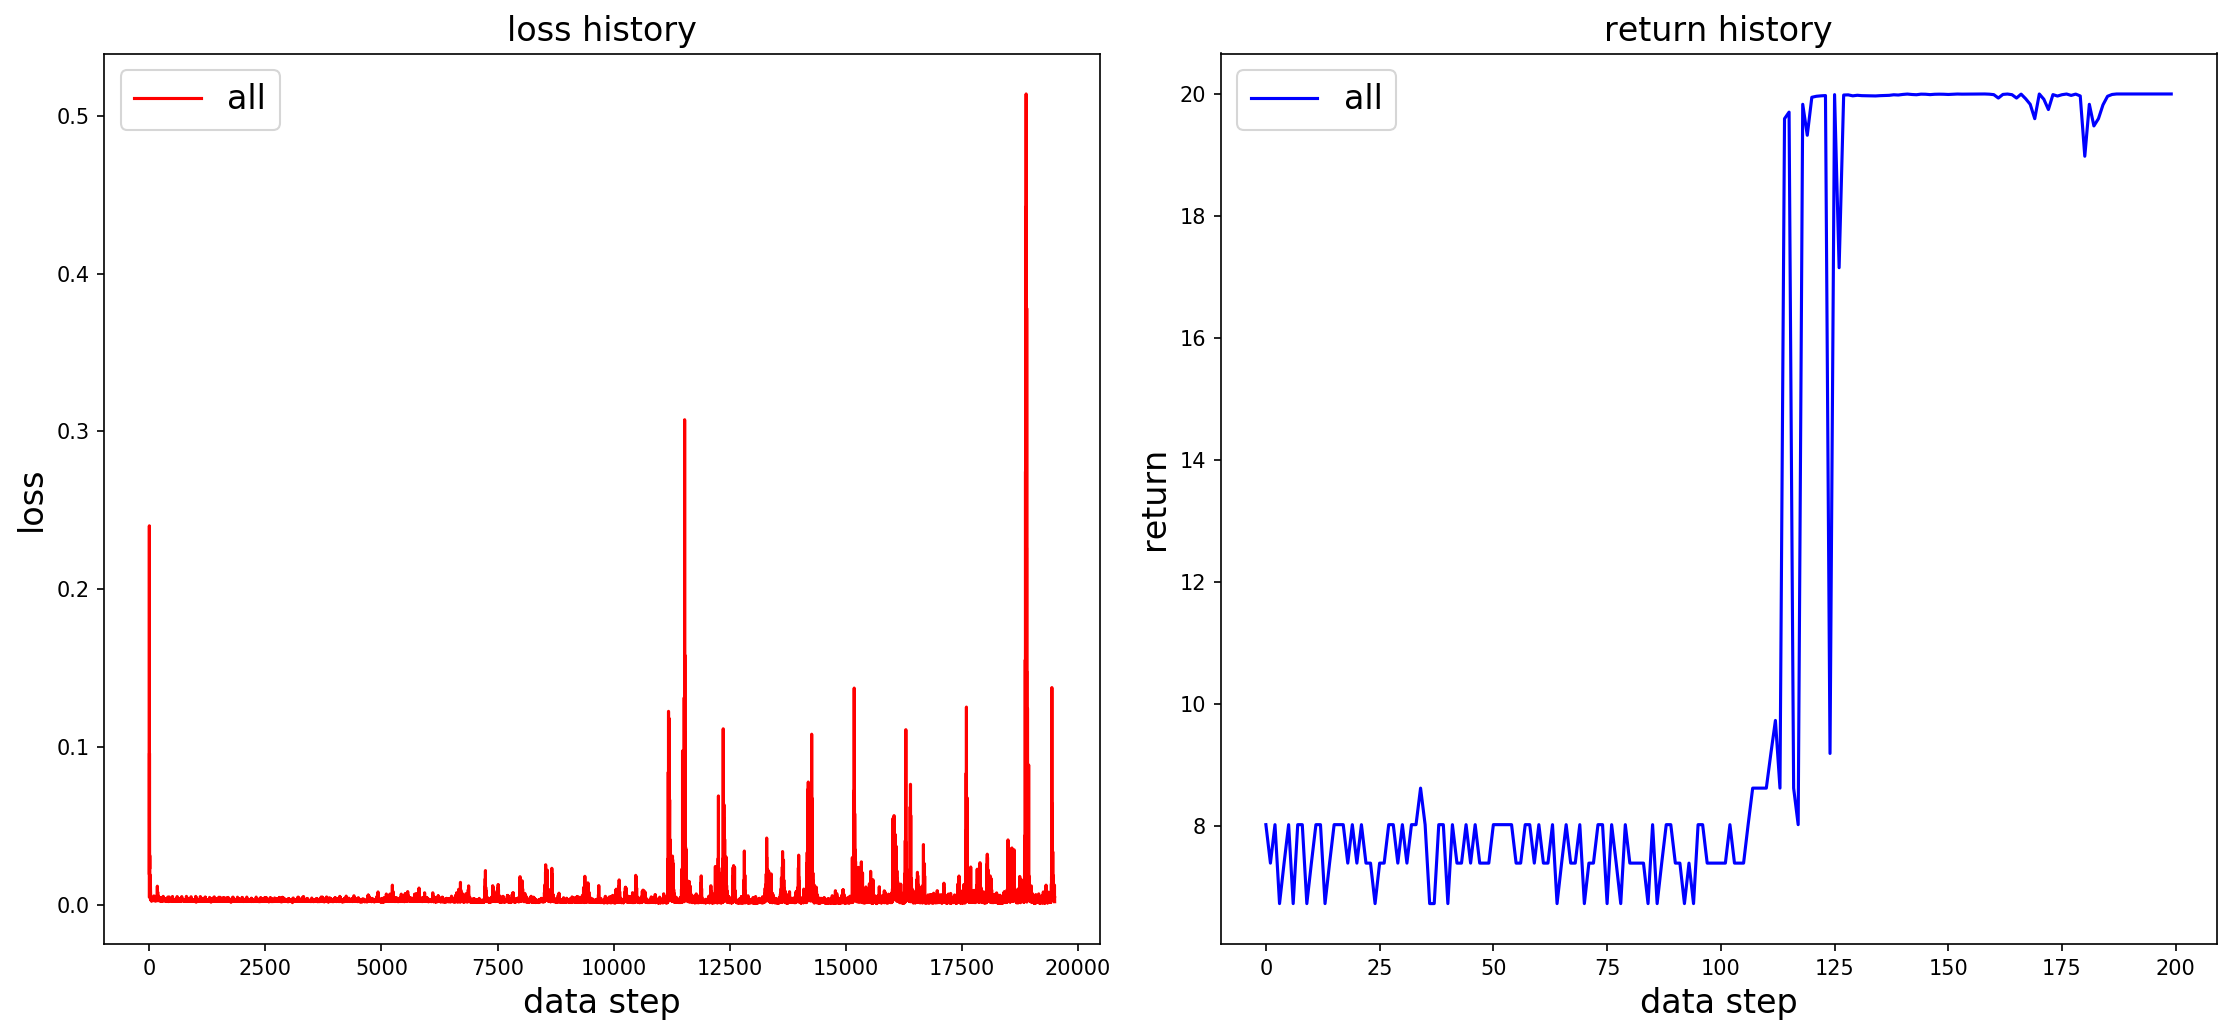

acquired action
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [1]
action =  [0]
action =  [1]
action =  [0]
action =  [0]
action =  [1]
action =  [0]
action =  [1]
action =  [1]
action =  [0]
action =  [0]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [1]
action =  [1]
action =  [1]
action =  [0]
action =  [0]
action =  [0]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [1]
action =  [1]
action =  [0]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [0]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [1]
action =  [0]
action =  [1]
action =  [0]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [0]
action =  [1]
action =  [0]
action =  [1]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [0]
action =  [1]
action =  [0]
action =  [0]
action =  [1]
action =  [1]
action =  [0]
action =  [0]
action =  [1]
acti

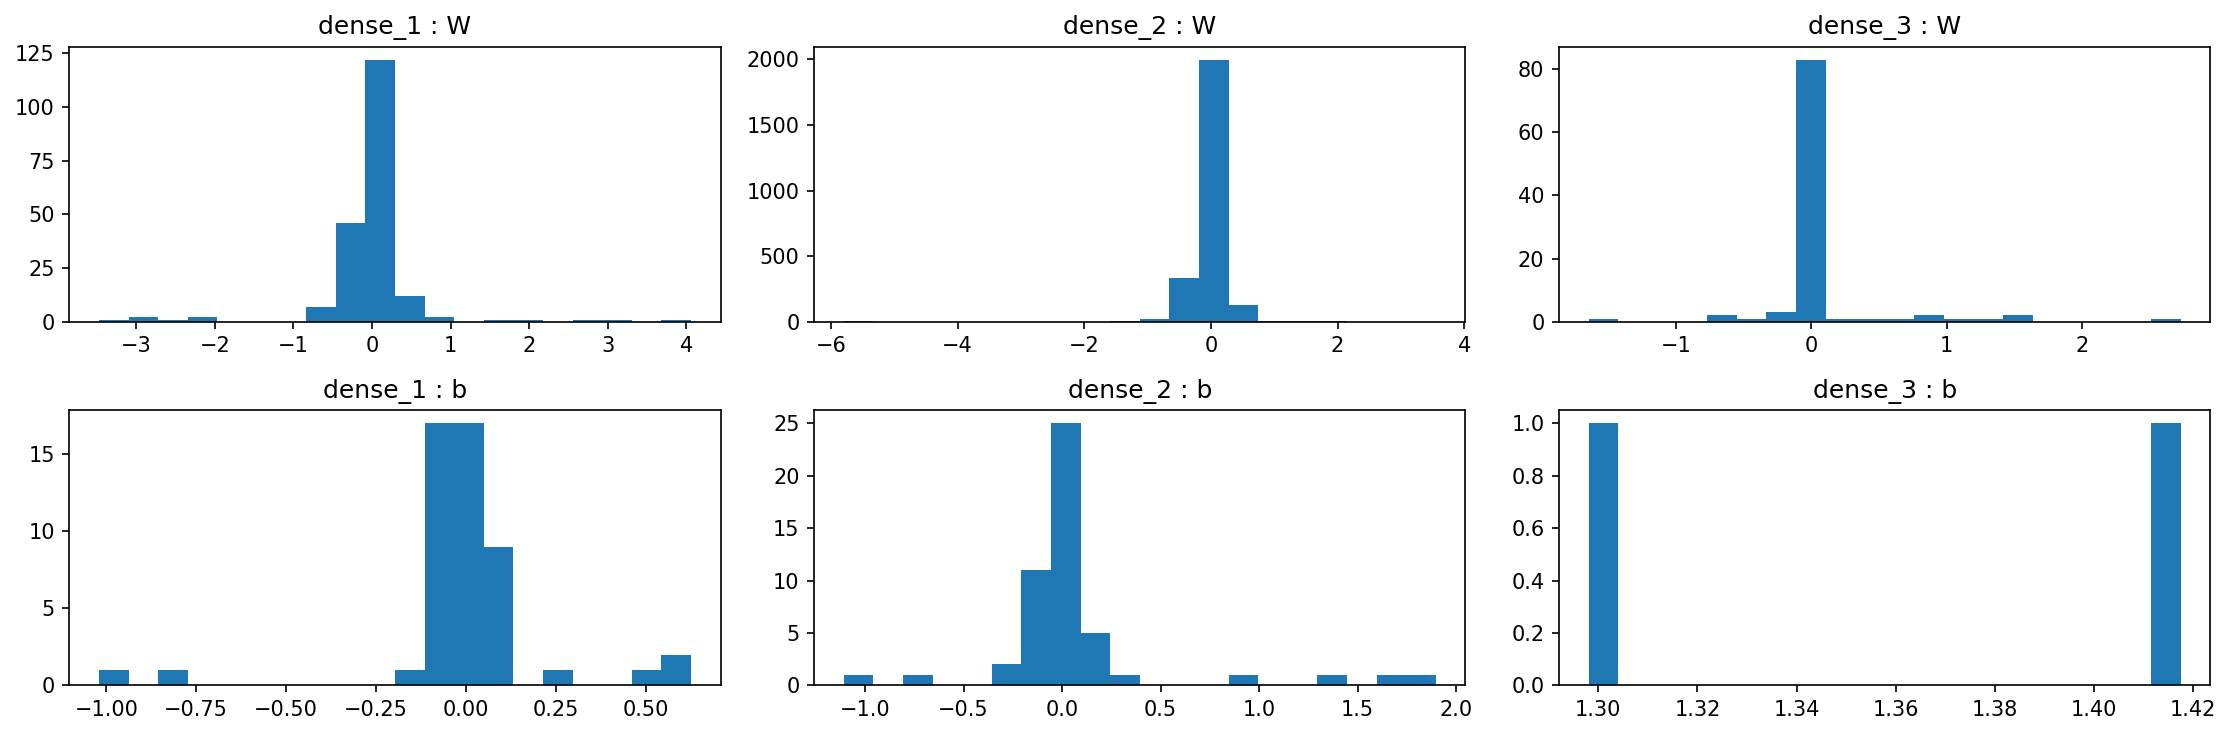

In [9]:
import DQN
importlib.reload(DQN)
from keras import optimizers

model = gen_model(input_shapes=[[4, ]], n_outputs=2,
                          hidden_dims=[50, 50])

tester = DQN.Tester(env_lap, model)
tester.test(n_trials=1, n_steps=20000,
           training_interval=1, n_batches=1, batch_size=32,
           target_update_interval=100,
           gamma=0.95, optimizer=optimizers.Adam(lr=1e-2),
           epsilon_start=1.0, epsilon_end=0.1, epsilon_interval=20000, 
           get_log=True)